<a href="https://colab.research.google.com/github/nicoeiris11/ac-gan/blob/main/AC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nicolás Eiris (182713) - Adrián Maximiliano Rial (174096)

### Obligatorio - Taller de Deep Learning

In [ ]:
import time
import torch
import torchvision
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### [Paper AC-GAN](https://arxiv.org/pdf/1610.09585.pdf)

In [ ]:
BATCH_SIZE = 100
NUM_CLASSES = 10

In [ ]:
def get_dataloader(train_transf, batch_size):
  train_dataset = CIFAR10("data", train=True, download=True, transform=train_transf)
  return DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

In [ ]:
def train(generator_model, discriminator_model, loader, real_fake_criterion, class_criterion, generator_optim, discriminator_optim, number_epochs):
  gen_train_history = []
  discr_train_history = []
  accuracy_history = []

  for epoch in range(number_epochs):
      start_time = time.time()

      gen_train_loss, discr_train_loss, accuracy = train_epoch(epoch, generator_model, discriminator_model, loader, real_fake_criterion, class_criterion, generator_optim, discriminator_optim)
      gen_train_history.append(gen_train_loss)
      discr_train_history.append(discr_train_loss)
      accuracy_history.append(accuracy)
      print("Training epoch {} | Generator Loss {:.6f} | Discriminator Loss {:.6f} | Class Accuracy {:.2f} | Time {:.2f} seconds"
            .format(epoch + 1, gen_train_loss, discr_train_loss, accuracy, time.time() - start_time))
      
  return gen_train_history, discr_train_history, accuracy_history

In [ ]:
real_tensor = torch.ones(BATCH_SIZE).view(-1, 1).to(device)
fake_tensor = torch.zeros(BATCH_SIZE).view(-1, 1).to(device)

In [ ]:
def train_epoch(epoch, generator_model, discriminator_model, loader, real_fake_criterion, class_criterion, generator_optim, discriminator_optim):
  eval_noise = torch.randn((BATCH_SIZE, 100, 1, 1))
  eval_labels = torch.LongTensor(BATCH_SIZE).random_(0, NUM_CLASSES)
    
  eval_encoder = OneHotEncoder(sparse=False, categories=[[0,1,2,3,4,5,6,7,8,9]])
  encoded_eval_labels = torch.LongTensor(eval_encoder.fit_transform(eval_labels.reshape(-1,1))).reshape(100, 10, 1, 1)
  eval_noise = torch.cat((eval_noise, encoded_eval_labels), dim = 1).flatten(1).to(device)

  generator_model.train()
  discriminator_model.train()

  generator_epoch_loss = 0.0
  discriminator_epoch_loss = 0.0

  all_labels = []
  all_predictions = []

  for real_images, real_labels in loader:
    all_labels.extend(real_labels.numpy())
    
    # Train Discriminator
    
    real_images = real_images.to(device)
    real_labels = real_labels.to(device)
    
    # Real images
    discriminator_optim.zero_grad()

    result_discriminator, result_class = discriminator_model(real_images)
    all_predictions.extend(torch.argmax(result_class, dim=1).cpu().numpy())
    error_real = real_fake_criterion(result_discriminator.view(-1, 1), real_tensor) + class_criterion(result_class, real_labels)
    error_real.backward()
    discriminator_optim.step()
    discriminator_epoch_loss += error_real.item()

    # Fake images
    discriminator_optim.zero_grad()

    random_noise = torch.randn((BATCH_SIZE, 100, 1, 1))
    random_labels = torch.LongTensor(BATCH_SIZE).random_(0, NUM_CLASSES)
    all_labels.extend(random_labels.numpy())

    labelsEncoder = OneHotEncoder(sparse=False, categories=[[0,1,2,3,4,5,6,7,8,9]])
    encoded_labels = torch.LongTensor(labelsEncoder.fit_transform(random_labels.reshape(-1,1))).reshape(100, 10, 1, 1)
    random_noise = torch.cat((random_noise, encoded_labels), dim = 1).flatten(1)
   
    random_noise = random_noise.to(device)
    random_labels = random_labels.to(device)
    
    generator_images = generator_model(random_noise)
    result_discriminator, result_class = discriminator_model(generator_images.detach())
    all_predictions.extend(torch.argmax(result_class, dim=1).cpu().numpy())
    error_fake = real_fake_criterion(result_discriminator.view(-1, 1), fake_tensor) + class_criterion(result_class, random_labels)
    error_fake.backward()
    discriminator_optim.step()
    discriminator_epoch_loss += error_fake.item()


    # Train Generator
    generator_optim.zero_grad()

    result_discriminator, result_class = discriminator_model(generator_images)

    generator_error = real_fake_criterion(result_discriminator.view(-1, 1), real_tensor) + class_criterion(result_class, random_labels)
    generator_error.backward()
    generator_optim.step()
    generator_epoch_loss += generator_error.item()

  constructed = generator_model(eval_noise)
  vutils.save_image(
    constructed.data,
    '%s/results_epoch_%03d.png' % ('images/', epoch)
    )
 
  return generator_epoch_loss / len(loader), discriminator_epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100

In [ ]:
class Generator(nn.Module):
  def __init__(self, out_channels = 3):
    super(Generator, self).__init__()
    
    self.linear = nn.Linear(in_features=110, out_features=384)
    
    self.transposed_conv1 = nn.ConvTranspose2d(in_channels=384, out_channels=192, kernel_size=5, stride=2, bias=False)
    self.batch_norm_1 = nn.BatchNorm2d(num_features=192)

    self.transposed_conv2 = nn.ConvTranspose2d(in_channels=192, out_channels=96, kernel_size=4, dilation = 2, stride= 2, bias=False)
    self.batch_norm_2 = nn.BatchNorm2d(num_features=96)

    self.transposed_conv3 = nn.ConvTranspose2d(in_channels=96, out_channels=out_channels, kernel_size=4, stride=2, bias=False)

  def forward(self, input):
    input = input.flatten(1)
    result = F.relu(self.linear(input))

    result = result.view(-1, 384, 1, 1)

    result = F.relu(self.batch_norm_1(self.transposed_conv1(result)))

    result = F.relu(self.batch_norm_2(self.transposed_conv2(result)))

    result = torch.tanh(self.transposed_conv3(result))
    
    return result

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, num_classes, in_channels = 3):
    super(Discriminator, self).__init__()
    self.num_classes = num_classes

    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False)

    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
    self.batch_norm_2 = nn.BatchNorm2d(num_features=32)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False)
    self.batch_norm_3 = nn.BatchNorm2d(num_features=64)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False)
    self.batch_norm_4 = nn.BatchNorm2d(num_features=128)

    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False)
    self.batch_norm_5 = nn.BatchNorm2d(num_features=256)

    self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False)
    self.batch_norm_6 = nn.BatchNorm2d(num_features=512)

    # 32/2/2/2 = 4 (kernel=3, stride=2)
    self.linear_discriminator = nn.Linear(in_features=512*4*4, out_features=1)
    self.linear_class = nn.Linear(in_features=512*4*4, out_features=self.num_classes)
    
    self.dropout = nn.Dropout()
    
  def forward(self, input):
    result = self.conv1(input)
    result = F.leaky_relu(result, negative_slope=0.2)
    result = self.dropout(result)

    result = self.batch_norm_2(self.conv2(result))
    result = F.leaky_relu(result, negative_slope=0.2)
    result = self.dropout(result)

    result = self.batch_norm_3(self.conv3(result))
    result = F.leaky_relu(result, negative_slope=0.2)
    result = self.dropout(result)

    result = self.batch_norm_4(self.conv4(result))
    result = F.leaky_relu(result, negative_slope=0.2)
    result = self.dropout(result)

    result = self.batch_norm_5(self.conv5(result))
    result = F.leaky_relu(result, negative_slope=0.2)
    result = self.dropout(result)

    result = self.batch_norm_6(self.conv6(result))
    result = F.leaky_relu(result, negative_slope=0.2) 
    result = self.dropout(result)

    result = result.flatten(1)

    result_discriminator = torch.sigmoid(self.linear_discriminator(result))
    result_class = self.linear_class(result)

    return result_discriminator, result_class

### Training

In [ ]:
def generate_images(generator_model):
    generator_model.eval()

    minibatch_size = 32

    random_noise = torch.randn((minibatch_size, 100, 1, 1))
    labelsEncoder = OneHotEncoder(sparse=False, categories=[[0,1,2,3,4,5,6,7,8,9]])
    random_labels = torch.LongTensor(minibatch_size).random_(0, NUM_CLASSES)
    encoded_labels = torch.LongTensor(labelsEncoder.fit_transform(random_labels.reshape(-1,1))).reshape(minibatch_size, 10, 1, 1)
    random_noise = torch.cat((random_noise, encoded_labels), dim = 1).flatten(1)

    random_noise = random_noise.to(device)
    
    generator_images = generator_model(random_noise)

    grid = make_grid(generator_images)
    npimg = grid.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [ ]:
def weights_init(m):
		classname = m.__class__.__name__
		if classname.find('Conv') != -1:
			m.weight.data.normal_(0.0, 0.02)
		elif classname.find('BatchNorm') != -1:
			m.weight.data.normal_(1.0, 0.02)
			m.bias.data.fill_(0)

In [ ]:
def train_gan(learning_rate):
  NUMBER_EPOCHS = 100

  generator_model = Generator().to(device)
  discriminator_model = Discriminator(NUM_CLASSES).to(device)

  generator_model.apply(weights_init)
  discriminator_model.apply(weights_init)

  discriminator_loss = nn.BCELoss().to(device)
  class_loss = nn.CrossEntropyLoss().to(device)
    
  generator_optim = torch.optim.Adam(generator_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
  discriminator_optim = torch.optim.Adam(discriminator_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  loader = get_dataloader(transform, BATCH_SIZE)

  generator_loss, discriminator_loss, accuracy_history = train(generator_model, discriminator_model, loader, discriminator_loss, class_loss, generator_optim, discriminator_optim, NUMBER_EPOCHS)
  plt.plot(generator_loss, label='Generator loss')
  plt.plot(discriminator_loss, label='Discriminator loss')
  plt.title('Loss of AC-GAN')
  plt.legend()
  plt.show()

  plt.plot(accuracy_history, label='Accuracy')
  plt.title('Class accuracy of AC-GAN')
  plt.legend()
  plt.show()

  generate_images(generator_model)

#### Train AC-GAN with paper hyperparams

 TRAIN AC-GAN WITH LEARNING RATE: 0.0001
Files already downloaded and verified
Training epoch 1 | Generator Loss 4.190298 | Discriminator Loss 5.462050 | Class Accuracy 16.14 | Time 25.80 seconds
Training epoch 2 | Generator Loss 4.454615 | Discriminator Loss 5.248686 | Class Accuracy 19.94 | Time 25.72 seconds
Training epoch 3 | Generator Loss 3.707474 | Discriminator Loss 4.835983 | Class Accuracy 27.01 | Time 25.45 seconds
Training epoch 4 | Generator Loss 3.417063 | Discriminator Loss 4.498685 | Class Accuracy 33.54 | Time 25.46 seconds
Training epoch 5 | Generator Loss 3.057861 | Discriminator Loss 4.110046 | Class Accuracy 44.45 | Time 25.62 seconds
Training epoch 6 | Generator Loss 2.747682 | Discriminator Loss 3.694401 | Class Accuracy 54.13 | Time 25.38 seconds
Training epoch 7 | Generator Loss 2.559175 | Discriminator Loss 3.543719 | Class Accuracy 58.80 | Time 25.34 seconds
Training epoch 8 | Generator Loss 2.347629 | Discriminator Loss 3.293129 | Class Accuracy 63.72 | Time

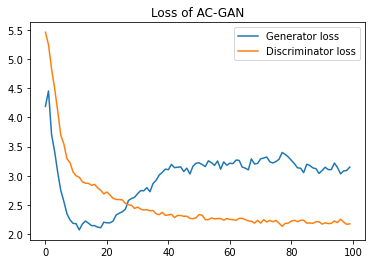

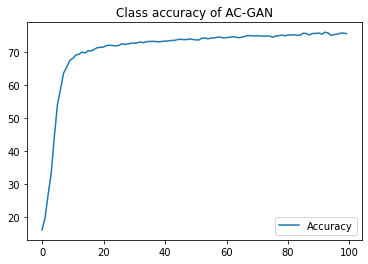

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


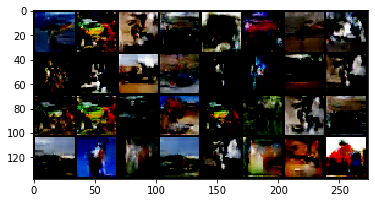

In [ ]:
print(" TRAIN AC-GAN WITH LEARNING RATE: 0.0001")
train_gan(0.0001)

 TRAIN AC-GAN WITH LEARNING RATE: 0.0002
Files already downloaded and verified
Training epoch 1 | Generator Loss 5.526386 | Discriminator Loss 5.231997 | Class Accuracy 17.36 | Time 26.11 seconds
Training epoch 2 | Generator Loss 5.556048 | Discriminator Loss 5.105362 | Class Accuracy 21.87 | Time 25.90 seconds
Training epoch 3 | Generator Loss 4.569559 | Discriminator Loss 4.594346 | Class Accuracy 29.34 | Time 26.09 seconds
Training epoch 4 | Generator Loss 4.586558 | Discriminator Loss 4.232179 | Class Accuracy 35.78 | Time 26.07 seconds
Training epoch 5 | Generator Loss 4.080942 | Discriminator Loss 3.802292 | Class Accuracy 48.06 | Time 26.10 seconds
Training epoch 6 | Generator Loss 3.570954 | Discriminator Loss 3.286512 | Class Accuracy 60.16 | Time 26.24 seconds
Training epoch 7 | Generator Loss 3.308139 | Discriminator Loss 3.080261 | Class Accuracy 64.37 | Time 26.19 seconds
Training epoch 8 | Generator Loss 3.101599 | Discriminator Loss 3.070489 | Class Accuracy 65.71 | Time

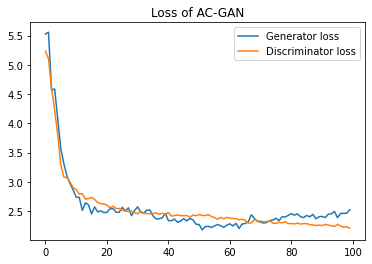

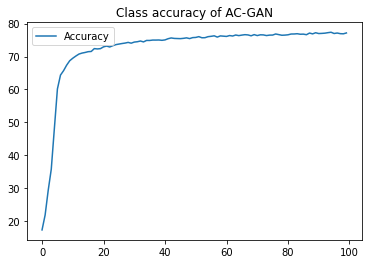

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


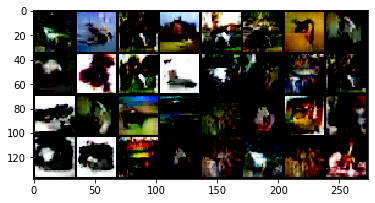

In [ ]:
print(" TRAIN AC-GAN WITH LEARNING RATE: 0.0002")
train_gan(0.0002)

 TRAIN AC-GAN WITH LEARNING RATE: 0.0003
Files already downloaded and verified
Training epoch 1 | Generator Loss 6.164231 | Discriminator Loss 5.165681 | Class Accuracy 17.76 | Time 25.43 seconds
Training epoch 2 | Generator Loss 6.348873 | Discriminator Loss 4.856693 | Class Accuracy 24.38 | Time 25.47 seconds
Training epoch 3 | Generator Loss 5.317616 | Discriminator Loss 4.519266 | Class Accuracy 31.13 | Time 25.42 seconds
Training epoch 4 | Generator Loss 4.936650 | Discriminator Loss 4.018283 | Class Accuracy 40.03 | Time 25.39 seconds
Training epoch 5 | Generator Loss 4.383757 | Discriminator Loss 3.359237 | Class Accuracy 55.98 | Time 25.42 seconds
Training epoch 6 | Generator Loss 3.909264 | Discriminator Loss 3.092320 | Class Accuracy 62.99 | Time 25.49 seconds
Training epoch 7 | Generator Loss 3.837305 | Discriminator Loss 2.954951 | Class Accuracy 65.94 | Time 25.45 seconds
Training epoch 8 | Generator Loss 3.373765 | Discriminator Loss 2.871835 | Class Accuracy 67.64 | Time

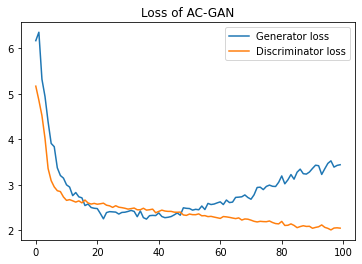

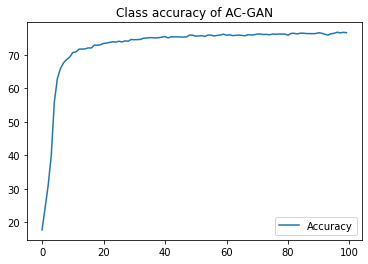

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


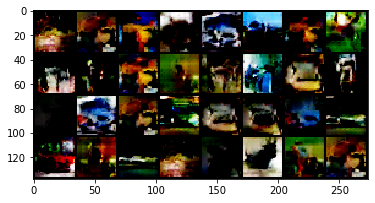

In [ ]:
print(" TRAIN AC-GAN WITH LEARNING RATE: 0.0003")
train_gan(0.0003)

## Conclusiones

### Motivación

Durante el curso, a ambos integrantes del equipo nos interesó el campo de Computer Vision. En particular, nos llamó la atención los distintos escenarios de aplicabilidad que se podrían lograr con una GAN, lo que nos llevó a imaginar distintos escenarios de uso de las mismas. Además, nos pareció interesante el mecanismo de entrenamiento en el cual dos redes "compiten" entre sí, por lo que decidimos profundizar en dicha arquitectura.

En una primera instancia evaluamos implementar la GAN clásica (en la que se basa este paper), pero al ser del 2014 y ya existir una gran cantidad de versiones con las que se ha logrado evolucionar dicho modelo, decidimos buscar una arquitectura más moderna que a su vez que nos proveyera un desafio extra en el trabajo.

Al encontrar el paper de "Conditional Image Synthesis with Auxiliary Classifier GANs", nos pareció muy interesante la posibilidad de generar imagenes de clases determinadas, y a su vez como tener un discriminador que clasifique las distintas imagenes podía ayudar a lograr mejores resultados.

### Dinámica del equipo

Previo a analizar los detalles técnicos del trabajo, quisieramos dar a conocer brevemente como fue el funcionamiento del equipo a lo largo del obligatorio.

Ambos estuvimos de acuerdo que era más conveniente desarrollar el trabajo en conjunto, por lo que buscamos tener reuniones periódicas para avanzar con la entrega, aprovechando para discutir ideas y así generar una mayor base de conocimiento. Dichas sesiones fueron en modalidad de videollamada donde alternábamos quien compartía la pantalla.

Esta estrategia de trabajo fue sumamente positiva ya que permitió compartir y encontrar ideas constantemente, así como también detectar errores en etapas tempranas (gran ventaja de la programación de a pares).

A su vez, en momentos en los que aún no podíamos conseguir resultados, ambos integrantes aprovechamos los momentos que teníamos disponibles (aunque el otro no pudiese juntarse), para lograr encontrar los detalles que tuviese nuestra implementación.




### Implementación de AC-GAN


#### Arquitectura

Para la implementación tanto del generador como del discriminador nos basamos en los lineamientos presentados por los autores. En el paper se presenta la arquitectura tanto para el dataset de ImageNet como de Cifar-10. En la siguiente imágen se puede visualizar la arquitectura presentada para el dataset de Cifar-10:

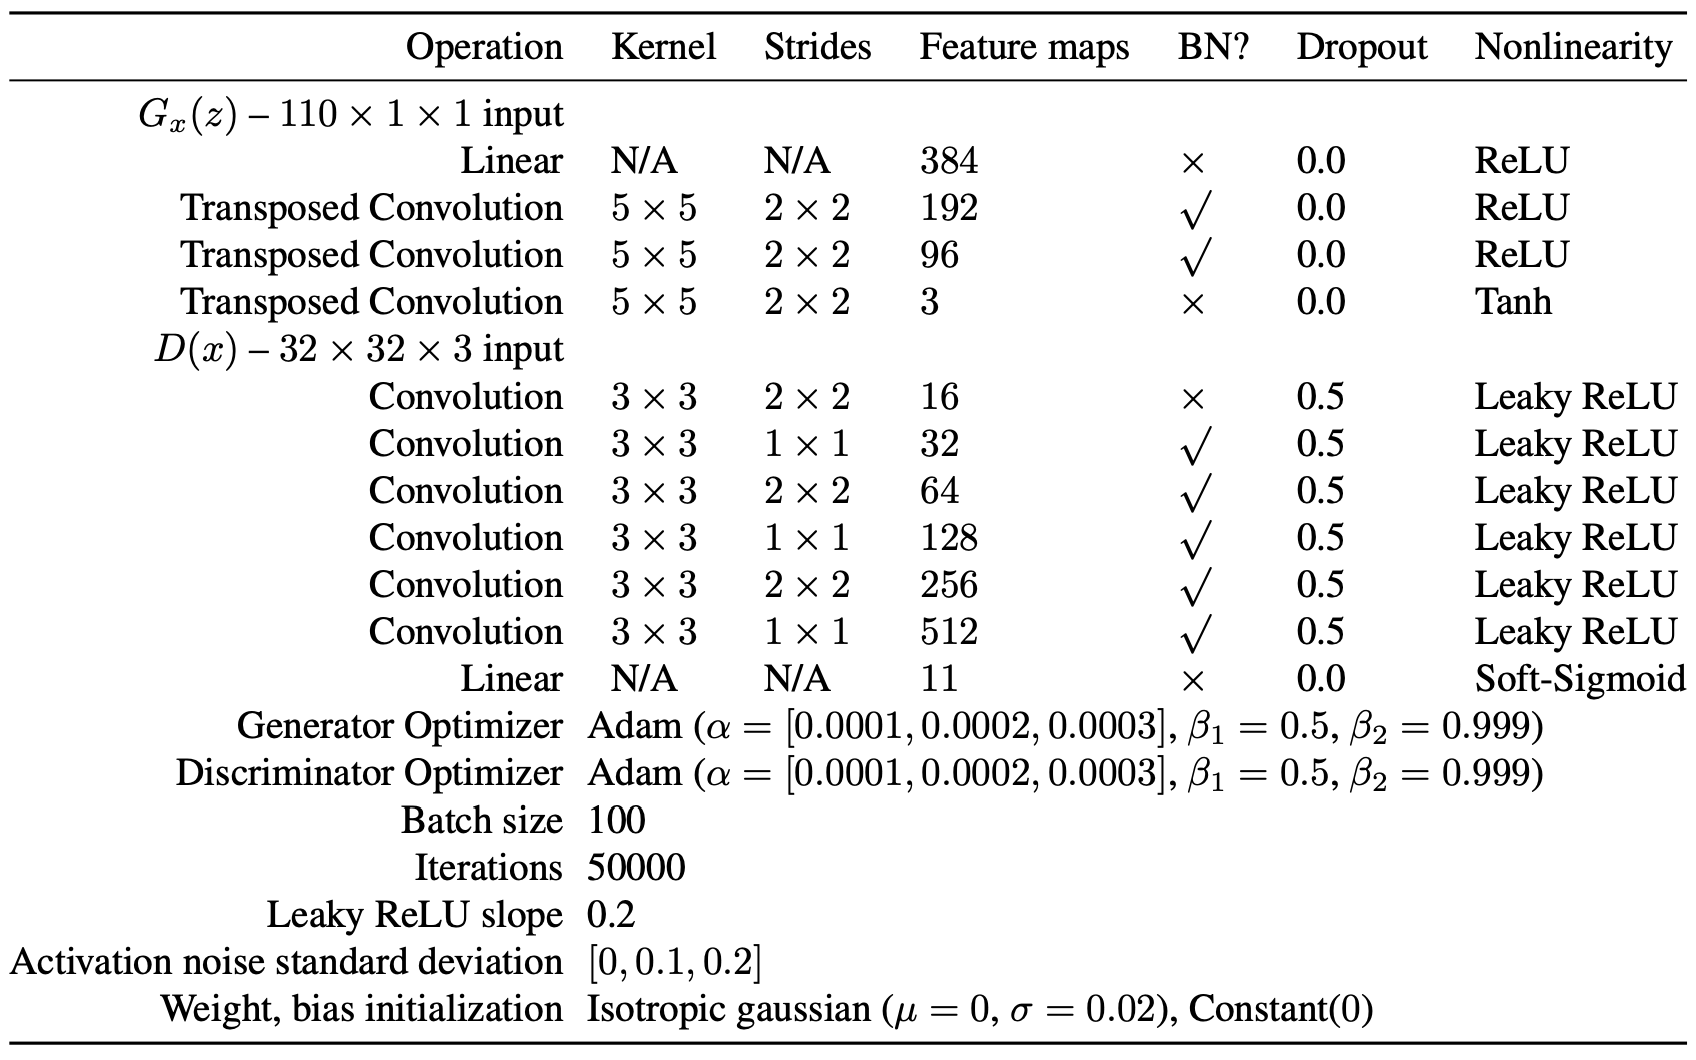




Vale aclarar que nos vimos forzados a realizar pequeñas modificaciones sobre algunos componentes del generador en específico. El paper no aclara ningún mecanismo de padding referente a las deconvoluciones, y si tenemos en cuenta que el dataset Cifar-10 cuenta con imágenes de 32x32 px, la salida del generador no coincide con una imágen de estas dimensiones. A continuación presentamos la fórmula para el calculo de dimensión de W de una [deconvolución](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) en Pytorch.

```
Wout = (Win−1) × stride[1] − 2×padding[1] + dilation[1] × (kernel_size[1]−1) + output_padding[1] + 1
```
Si vemos la tabla de arquitectura presentada por los autores todas las deconvoluciones del generador se presentan con kernel=5 y stride=2 (asumimos que no hay padding ya que en el paper no se menciona nada al respecto, además el [dilation](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#dilated-convolution-animations) por defecto es de 1). Presentamos los calculos a mano que hicimos respecto a las dimensiones y deconvoluciones...

*   Deconv1
  - Input: 1x1
  - Deconv: (1 - 1) * 2 - 2 * 0 + 1 * (5 - 1) + 0 + 1 = 5
  - Output: 5x5

*   Deconv1
  - Input: 5x5
  - Deconv: (5 - 1) * 2 - 2 * 0 + 1 * (5 - 1) + 0 + 1 = 13
  - Output: 13x13

*   Deconv1
  - Input: 13x13
  - Deconv: (13 - 1) * 2 - 2 * 0 + 1 * (5 - 1) + 0 + 1 = 29
  - Output: 29x29

Podemos ver como la dimension de imagen de salida del generador es de 29x29 si aplicamos los lineamientos presentados en la tabla de arquitectura.

Como una primer estrategia para iterar rápidamente tomamos la decisión de agregar padding a la salida del generador transformando una imágen de 29x29 a una de 32x32. Esto permitió poder integrar el generador y el discriminador con el objetivo de entrenar y obtener los primeros resultados. Esta no fue una buena estrategia ya que claramente el discriminador facilmente identificaba cual era una imágen real y cuál no (ya que en las generadas habia 3px de padding a la derecha y abajo de la imágen).

Aquí se puede observar una de las imágenes generadas con padding:

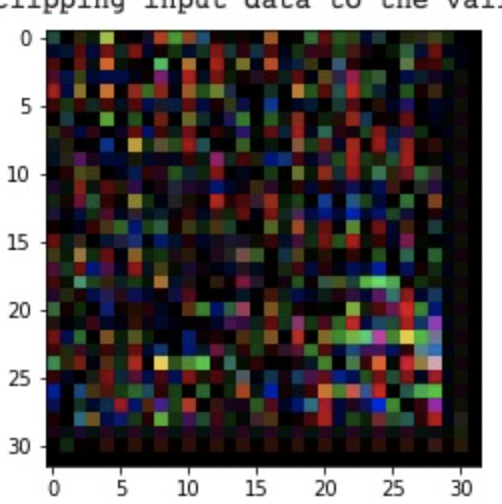












Como una segunda estrategia decidimos hacer un resize de las imágenes reales con el objetivo de evitar que el discriminador distinga entre reales y generadas facilmente. Los resultados no fueron buenos, si bien se notó una mejora respecto a la primera estrategia, el generador no era capaz de mejorar sus imágenes ya que al bajar la resolución las imágenes reales perdieron nitidez. A su vez, no es una buena estrategia deteriorar las imágenes reales para adaptar las dimensiones a lo generado. 

Teniendo esto en cuenta decidimos preservar las imágenes del dataset tal y como estaban y adaptar la arquitectura a las dimensiones naturales (32x32 px).
De aquí decidimos modificar unicamente la arquitectura del generador para retornar imágenes de 32x32 sin hacer uso del padding. Tomando en cuenta la fórmula presentada previamente y la necesidad de mantener la cantidad de deconvoluciones para alinearnos lo máximo posible con la arquitectura presentada por los autores, probamos múltiples combinaciones de tamaño de kernel, stride y dilation(éste último refiere a espacios entre las celdas del padding). Los mejores resultados los obtuvimos con la siguiente configuración:

*   Deconv1
    - kernel: 5
    - stride: 2
*   Deconv2
    - kernel: 4
    - stride: 2
    - dilation: 2
*   Deconv3
    - kernel: 4
    - stride: 2

Con esta nueva configuración del generador logramos obtener resultados muy buenos en tiempos relativamente cortos (se detallan en la sección de resultados). Claramente esta estrategia fue sumamente positiva para el aprendizaje tanto del discriminador como del generador.

#### Entrenamiento

Para realizar el entrenamiento, decidimos seguir la implementación del paper lo más fiel posible.

Por esta razón, utilizamos el optimizador Adam tanto para el generador como para el discriminador, con los valores de betas definidos en el paper (b1 = 0.5 y b2 = 0.999). En cuanto al learning rate, experimentamos con los tres valores presentados (0.0001, 0.0002 y 0.0003).

Como funciones de costo, utilizamos BCELoss para medir la binary cross entropy entre el target (real/trucha) y la salida de la Sigmoid, y Cross Entropy para comparar la etiqueta del resultado de la clasificación de la imagen. Dado que la función de CrossEntropyLoss de Pytorch ya hace el softmax internamente al calcular la loss, no se agregó dicha función dentro de la arquitectura del discriminador.

Al entrenar con CIFAR-10, los autores de la arquitectura entrenaron por 50000 iteraciones de batch de tamaño 100. En nuestro caso, decidimos realizar nuestro entrenamiento en epochs. Dado que el dataset de CIFAR-10 tiene 50000 imagenes de entrenamiento, corrimos 100 epochs (con minibatch de 100 elementos como menciona el paper), lo que sería el equivalente a dicha cantidad de iteraciones.




#### Resultados

Luego de realizar varios experimentos y de evaluar las imágenes generadas, así como también observar como fue su evolución durante todo el proceso de entrenamiento, podemos afirmar que la arquitectura logró efectivamente aprender a generar imágenes.

En nuestro caso el learning rate = 0.0002 fue el que mostró mejor evolución en el tiempo si observamos las gráficas. Igualmente todas las configuraciones de hyper-paramámetros que menciona el paper funcionaron muy bien en nuestra implementación. 

## Experimentos adicionales

Una vez finalizada la implementación que se encuentra en el paper, decidimos utilizar la solución con otro dataset que ya conociamos y que no se menciona en el paper. 

Decidimos probar generar imágenes para el dataset de FASHION-MNIST. 

La única modificación que realizamos fue la cantidad de canales de entrada ya que MNIST maneja imágenes en blanco y negro. 

Mediante este experimento pudimos ver como en etapas tempranas del entrenamiento (epoch 3) ya se podian generar imágenes distinguibles, ya que se podían visualizar figuras similares a prendas reales:

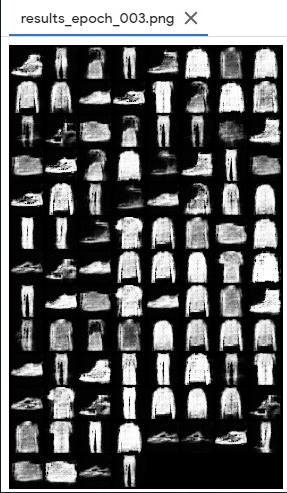



### Fashion MNIST

In [ ]:
from torchvision.datasets import FashionMNIST


In [ ]:
def get_Fashion_MNIST_dataloader(train_transf, batch_size):
  train_dataset = FashionMNIST("data", train=True, download=True, transform=train_transf)
  return DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

Training epoch 1 | Generator Loss 5.319153 | Discriminator Loss 4.190706 | Class Accuracy 38.83 | Time 31.70 seconds
Training epoch 2 | Generator Loss 5.268805 | Discriminator Loss 2.480390 | Class Accuracy 63.59 | Time 31.50 seconds
Training epoch 3 | Generator Loss 4.731917 | Discriminator Loss 1.357008 | Class Accuracy 84.00 | Time 31.27 seconds
Training epoch 4 | Generator Loss 4.720169 | Discriminator Loss 1.262712 | Class Accuracy 87.33 | Time 31.60 seconds
Training epoch 5 | Generator Loss 4.855680 | Discriminator Loss 1.133773 | Class Accuracy 88.83 | Time 31.52 seconds
Training epoch 6 | Generator Loss 4.428485 | Discriminator Loss 1.258662 | Class Accuracy 89.31 | Time 31.47 seconds
Training epoch 7 | Generator Loss 4.737604 | Discriminator Loss 1.141167 | Class Accuracy 89.19 | Time 31.29 seconds
Training epoch 8 | Generator Loss 4.427193 | Discriminator Loss 1.145695 | Class Accuracy 89.34 | Time 31.50 seconds
Training epoch 9 | Generator Loss 4.335856 | Discriminator Loss 

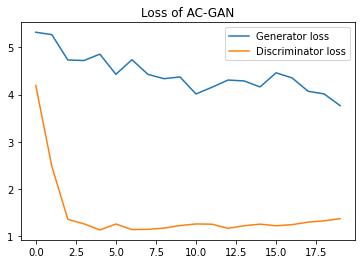

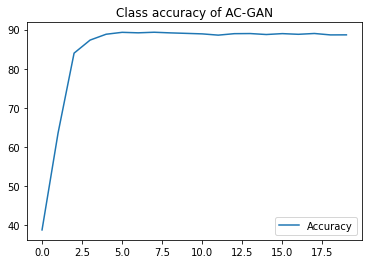

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


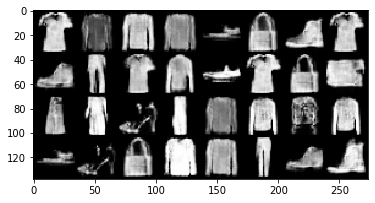

In [ ]:
NUMBER_EPOCHS = 20

generator_model = Generator(out_channels=1).to(device)
discriminator_model = Discriminator(NUM_CLASSES, in_channels = 1).to(device)

generator_model.apply(weights_init)
discriminator_model.apply(weights_init)

discriminator_loss = nn.BCELoss().to(device)
class_loss = nn.CrossEntropyLoss().to(device)
    
generator_optim = torch.optim.Adam(generator_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optim = torch.optim.Adam(discriminator_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

loader = get_Fashion_MNIST_dataloader(transform, BATCH_SIZE)

generator_loss, discriminator_loss, accuracy_history = train(generator_model, discriminator_model, loader, discriminator_loss, class_loss, generator_optim, discriminator_optim, NUMBER_EPOCHS)
plt.plot(generator_loss, label='Generator loss')
plt.plot(discriminator_loss, label='Discriminator loss')
plt.title('Loss of AC-GAN')
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy')
plt.title('Class accuracy of AC-GAN')
plt.legend()
plt.show()

generate_images(generator_model)

In [ ]:
def generate_images_by_label(generator_model, label):
    generator_model.eval()

    minibatch_size = 32

    random_noise = torch.randn((minibatch_size, 100, 1, 1))
    labelsEncoder = OneHotEncoder(sparse=False, categories=[[0,1,2,3,4,5,6,7,8,9]])
    random_labels = torch.LongTensor(minibatch_size).fill_(label)
    encoded_labels = torch.LongTensor(labelsEncoder.fit_transform(random_labels.reshape(-1,1))).reshape(minibatch_size, 10, 1, 1)
    random_noise = torch.cat((random_noise, encoded_labels), dim = 1).flatten(1)

    random_noise = random_noise.to(device)
    
    generator_images = generator_model(random_noise)

    grid = make_grid(generator_images)
    npimg = grid.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


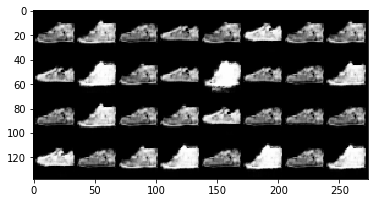

In [ ]:
generate_images_by_label(generator_model, 7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-- Fake images:


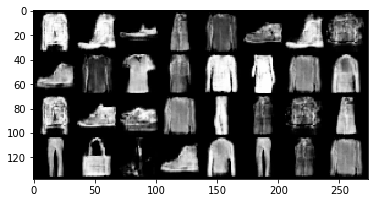

-- Real images:


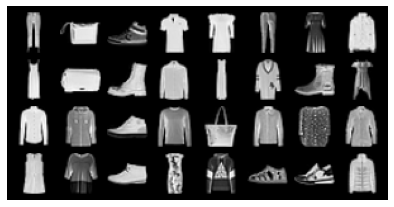

In [ ]:
print('-- Fake images:')
generate_images(generator_model)

print('-- Real images:')
real_batch = next(iter(loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(),(1,2,0)))